In [1]:
## Import libraries and useful functions

suppressMessages({
  library(ggplot2)
  library(terra)
  library(leaflet)
  library(tidyr)
  library(dplyr)
})

library(ggplot2)
library(terra)
library(leaflet)
library(tidyr)
library(dplyr)

source("../scripts/utils.R")

In [2]:
## Set paths and load data
# Input NVDI basemaps stored in country folder. 
# Area of Interest (AoI) files in AoI folder

country_name <- "Zambia"
data_type <- "NDVI"
resolution <- 100 # in meters
data_path <- paste0("../data/", data_type, "/", country_name, "/", resolution, "m_resolution/")
aoi_path <- "../data/AoI/"

test_year <- 2024


In [3]:
## Create lists with relevant filenames.
## Extract date, and order accordingly

# NDVI filenames
ndvi_files <- get_filenames(filepath = data_path, data_type = data_type, 
                            file_extension = ".tif", country_name = country_name)

# AoI filenames
aoi_files <- get_filenames(filepath = aoi_path, data_type = "AoI", 
                           file_extension = ".geojson", country_name = country_name)

# Extract the date part from the filenames using a regular expression
# Assumes only year and month in filename
dates <- extract_dates(file_list = ndvi_files)

# Convert extracted date strings to date objects
# sorting files based on the date objects (ascending)
ndvi_files <- order_by_date(file_list = ndvi_files, dates = dates, decreasing = FALSE)


Loading NDVI data for Zambia 

Loading AoI data for Zambia 

Found data for 72 months, from 2019-01 to 2024-12 



Loading AoI data for Zambia 

Found data for 48 months, from 2020-01 to 2023-12 


In [4]:
## Load raster and vector objects

# load input Area of Interest (AoI) to later mask data
aoi_proj <- get_aoi_vector(aoi_files = aoi_files, aoi_path = aoi_path,
                           projection = "EPSG:4326")

ndvi_msk <- get_ndvi_raster(ndvi_files = ndvi_files, data_path = data_path,
                            projection = "EPSG:4326", dates = dates,
                            aoi_proj = aoi_proj)


Reading layer `AoI_Mponda' from data source 
  `/home/user/data/AoI/AoI_Zambia_By_Life_Connected.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 26.77027 ymin: -15.1321 xmax: 26.92342 ymax: -14.85555
Geodetic CRS:  WGS 84


In [5]:
# Extract raster layers for each date
# and store in dataframe
ndvi_df <- get_ndvi_df(ndvi_rast = ndvi_msk, dates = dates) 

In [6]:
## now split df into train and test data
# train year data
train_ndvi_df <- ndvi_df[ndvi_df$Year != test_year,]
# test year data
test_ndvi_df <- ndvi_df[ndvi_df$Year == test_year,]

In [7]:
## drop missing values
#train_ndvi_df <- na.omit(train_ndvi_df)
#test_ndvi_df <- na.omit(test_ndvi_df)

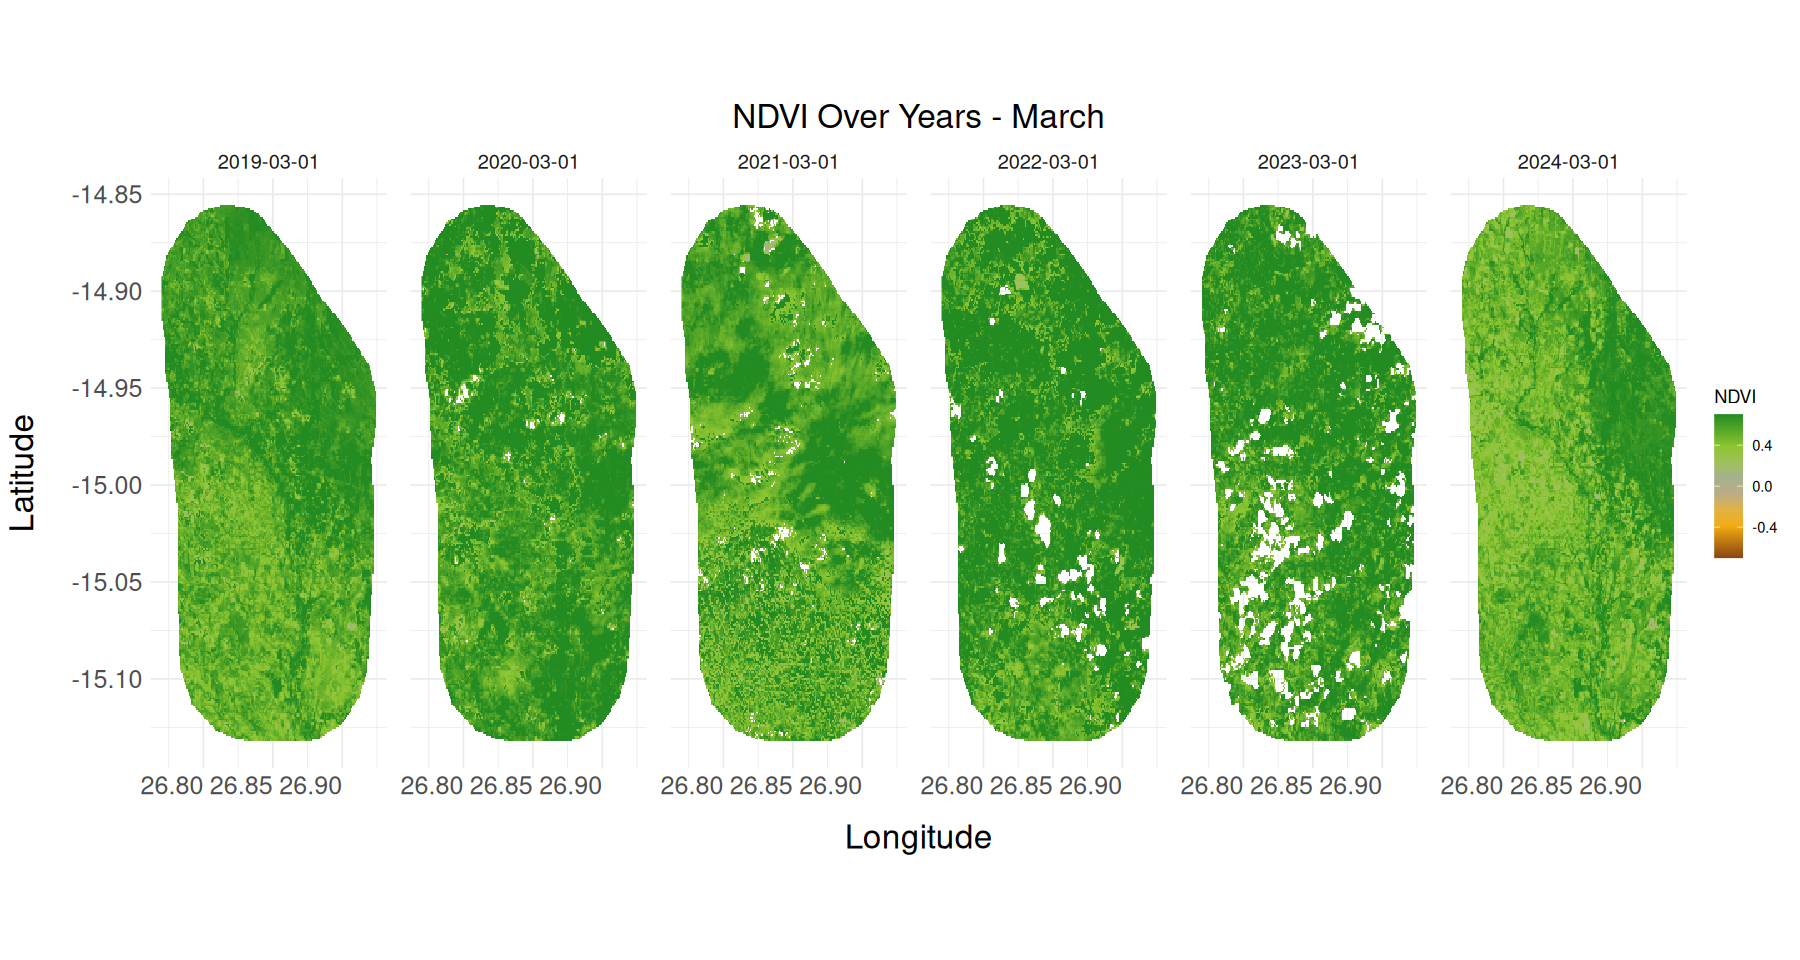

In [8]:
## Plot one month raster data, over years

month2plot <- "03"

# Change plot size to 15 x 8
options(repr.plot.width=15, repr.plot.height=8)

# Define a color map from brown to green
brgr.colors <- colorRampPalette(c("chocolate4", "darkgoldenrod1", "darkgray", "yellowgreen", "forestgreen"))

# train data
ggplot(ndvi_df[ndvi_df$Month == month2plot, ], aes(x = x, y = y, fill = NDVI)) +
  geom_raster() +
  scale_fill_gradientn(colors = brgr.colors(10), limits = c(-.7, .7), oob = scales::squish) +
  facet_wrap(~ YearMonth, ncol = 6) +
  labs(title = paste0("NDVI Over Years - ", month.name[as.numeric(month2plot)]), fill = "NDVI", x = "Longitude", y = "Latitude") +
  theme_minimal() +
  theme(
    aspect.ratio = 2.5, # Keep a consistent aspect ratio
    panel.spacing = unit(1, "lines"), # Space between panels
    strip.text = element_text(size = 12), # Adjust facet labels
    axis.text.x = element_text(hjust = 1, size = 15), 
    axis.text.y = element_text(size = 15), 
    axis.title.x = element_text(size = 20, margin = margin(15,0,0,0)),
    axis.title.y = element_text(size = 20, margin = margin(0,15,0,0)),
    plot.title = element_text(size = 20, hjust = 0.5)
  ) 

In [9]:
## compute NDVI deviation from baseline in 2D space

delta_ndvi_df <- get_delta_ndvi_df(train_ndvi_df = train_ndvi_df, test_ndvi_df = test_ndvi_df)

`summarise()` has grouped output by 'x', 'y'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'x', 'y'. You can override using the
`.groups` argument.


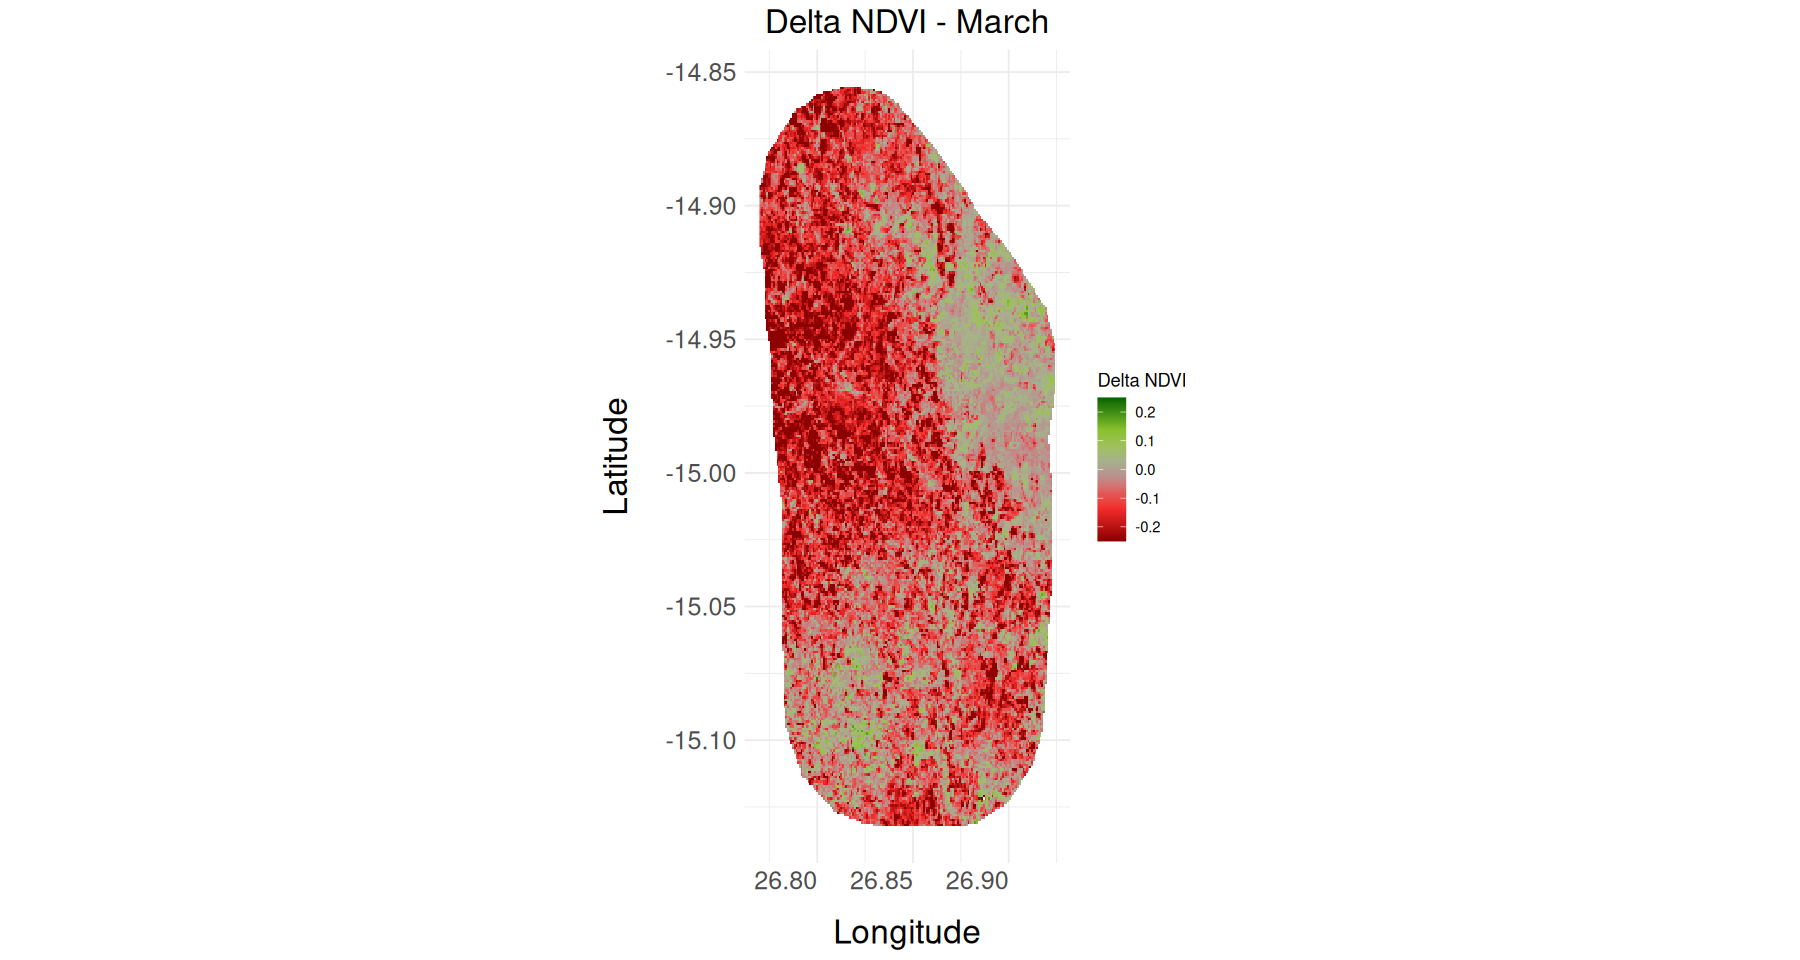

In [10]:
## Plot one month raster data, to show delta NDVI

month2plot <- "03"

# Change plot size to 15 x 8
options(repr.plot.width=15, repr.plot.height=8)

# Define a color map from brown to green
brgr.colors <- colorRampPalette(c("darkred", "firebrick1", "darkgray", "yellowgreen", "darkgreen"))

# train data
ggplot(delta_ndvi_df[delta_ndvi_df$Month == month2plot, ], aes(x = x, y = y, fill = delta_ndvi)) +
  geom_raster() +
  scale_fill_gradientn(colors = brgr.colors(10), limits = c(-.25, .25), oob = scales::squish) +
  labs(title = paste0("Delta NDVI - ", month.name[as.numeric(month2plot)]), fill = "Delta NDVI", x = "Longitude", y = "Latitude") +
  theme_minimal() +
  theme(
    aspect.ratio = 2.5, # Keep a consistent aspect ratio
    panel.spacing = unit(1, "lines"), # Space between panels
    strip.text = element_text(size = 12), # Adjust facet labels
    axis.text.x = element_text(hjust = 1, size = 15), 
    axis.text.y = element_text(size = 15), 
    axis.title.x = element_text(size = 20, margin = margin(15,0,0,0)),
    axis.title.y = element_text(size = 20, margin = margin(0,15,0,0)),
    plot.title = element_text(size = 20, hjust = 0.5)
  ) 